Link do Dataset no Kaggle: https://www.kaggle.com/datasets/prosperchuks/health-dataset?select=stroke_data.csv

1 - Introdução

O AVC pode ocorrer em qualquer idade. Mas o que é AVC? O AVC, também chamado de derrame cerebral, ocorre quando o fluxo sanguíneo para o cérebro é interrompido. A interrupção no fluxo sanguíneo é causada quando um coágulo de sangue bloqueia um dos vasos sanguíneos vitais no cérebro (AVC isquêmico) ou quando um vaso sanguíneo no cérebro estoura, derramando sangue nos tecidos circundantes (AVC hemorrágico).

Prever AVC pode prevenir danos irreversíveis entre a população em risco. O objetivo deste notebook é construir um modelo que preveja o AVC (classificação binária) com alta precisão e F1-Score (o objetivo é identificar todos os que vão ter um AVC, mas também tentando evitar falsos positivos) com base em vários recursos individuais. A previsão bem-sucedida pode trazer benefícios financeiros e de saúde.

2 - Sobre a base de dados

Este conjunto de dados é usado para prever se um paciente tem probabilidade de sofrer um derrame com base nos parâmetros de entrada, como sexo, idade, várias doenças e tabagismo. 

Sobre os dados: Cada linha nos dados fornece informações relevantes sobre uma pessoa, por exemplo; idade, sexo, tabagismo, ocorrência de acidente vascular cerebral, além de outras informações Desconhecido no status de fumante significa que as informações não estão disponíveis. N/A em outros campos de entrada significa que não é aplicável.

In [ ]:
# Carregamento das bibliotecas utilizadas no modelo
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score,confusion_matrix,classification_report,ConfusionMatrixDisplay

In [ ]:
# ignorar warnings
warnings.filterwarnings('ignore')

### Descrição da variáveis :


- `sex`: gênero do paciente ("Male", "Female" ou "Other")
- `age`: idade do paciente
- `hypertension`: 0 se o paciente não tem hipertensão, 1 se o paciente tem hipertensão
- `heart_disease`: 0 se o paciente não tem doença cardíaca, 1 se o paciente tem doença cardíaca
- `ever_married`: se o paciente já foi casado ("No" or "Yes")
- `work_type`: ocupação do paciente ("children", "Govt_jov", "Never_worked", "Private" or "Self-employed")
- `Residence_type`: tipo de moradia do paciente ("Rural" or "Urban")
- `avg_glucose_level`: nível médio de glicose no sangue
- `bmi`: índice de massa corporal
- `smoking_status`: se o paciente é fumante ("formerly smoked", "never smoked", "smokes" ou "Unknown"*)
- `stroke`: 1 se o paciente teve um derrame ou 0 se não teve derrame

 
`Nota: "Unknown" em 'smoking_status' significa que a informação não está disponível para este paciente`


### Importando Conjunto de Dados

In [ ]:
# Leitura dos dados
path = '/content/stroke_data.csv'
df_stroke = pd.read_csv(path,sep=",")

# Abaixo estão as primeiras 5 linhas do conjunto de dados
df_stroke.head()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,63.0,0,1,1,4,1,228.69,36.6,1,1
1,1.0,42.0,0,1,1,4,0,105.92,32.5,0,1
2,0.0,61.0,0,0,1,4,1,171.23,34.4,1,1
3,1.0,41.0,1,0,1,3,0,174.12,24.0,0,1
4,1.0,85.0,0,0,1,4,1,186.21,29.0,1,1


### Análise Exploratória de Dados

In [ ]:
# Verificando tipos de dados e informações das colunas
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40910 entries, 0 to 40909
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                40907 non-null  float64
 1   age                40910 non-null  float64
 2   hypertension       40910 non-null  int64  
 3   heart_disease      40910 non-null  int64  
 4   ever_married       40910 non-null  int64  
 5   work_type          40910 non-null  int64  
 6   Residence_type     40910 non-null  int64  
 7   avg_glucose_level  40910 non-null  float64
 8   bmi                40910 non-null  float64
 9   smoking_status     40910 non-null  int64  
 10  stroke             40910 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.4 MB


In [ ]:
# Abaixo está a forma do conjunto de dados
df_stroke.shape

(40910, 11)


- Podemos observar que a base de dados possui uma boa quantidade de observações.

In [ ]:
# Verificando os valores nulos
df_stroke.isna().sum()

sex                  3
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

- Nota-se que quase todas as colunas estão sem valores nulos e com o tipo correto de dados. Apenas a coluna de "sex" possui 3 valores nulos;

Como citado anteriormente, temos 3 valores nulos na coluna "sex". Vamos verificar abaixo quais são as linhas do dataframe com esses valores nulos:

In [ ]:
# Checando linhas com dados nulos
df_stroke[df_stroke['sex'].isna()]

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
22478,NaN,39.0,0,0,1,4,1,70.56,28.6,1,0
28908,NaN,36.0,0,0,1,4,1,70.56,28.6,1,0
35184,NaN,77.0,0,0,1,4,1,70.56,28.6,1,0


Como o dados faltantes representam uma proporção muito pequena em relação ao dataset completo (~0.007%), eles serão removidos da base de dados.


In [ ]:
# drop das linhas com valores nulos
df_stroke = df_stroke.dropna()

In [ ]:
# Verificando dados duplicados
print(f"Número de linhas duplicadas: {df_stroke.duplicated().sum()}")

Número de linhas duplicadas: 0


Não há dados duplicados no dataset, como pode ser observado pelo resultado acima.

In [ ]:
# Identificando a contagem itens distintos em cada variável
dict = {}
for i in list(df_stroke.columns):
    dict[i] = df_stroke[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
sex,2
age,111
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,2903
bmi,370
smoking_status,2


In [ ]:
# Resumo estatistico dos dados
df_stroke.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,40907.0,0.555162,0.496954,0.00,0.00,1.00,1.00,1.00
age,40907.0,51.327303,21.624171,-9.00,35.00,52.00,68.00,103.00
hypertension,40907.0,0.213851,0.410028,0.00,0.00,0.00,0.00,1.00
heart_disease,40907.0,0.127729,0.333792,0.00,0.00,0.00,0.00,1.00
ever_married,40907.0,0.821326,0.383083,0.00,1.00,1.00,1.00,1.00
work_type,40907.0,3.461095,0.780934,0.00,3.00,4.00,4.00,4.00
Residence_type,40907.0,0.514851,0.499786,0.00,0.00,1.00,1.00,1.00
avg_glucose_level,40907.0,122.079679,57.561951,55.12,78.75,97.92,167.59,271.74
bmi,40907.0,30.406488,6.835305,11.50,25.90,29.40,34.10,92.00
smoking_status,40907.0,0.488572,0.499875,0.00,0.00,0.00,1.00,1.00


Percebe-se que há um valor mínimo para a idade de -9 anos, o que não faz sentido. Com isso, o dataframe será filtrado para manter pacientes com valores válidos de idade.

In [ ]:
# Remoção de valores negativos de idade
df_stroke = df_stroke[df_stroke['age'] >= 0.0]
df_stroke.shape

(40849, 11)

In [ ]:
# Checando resumo estatistico dados atualizados
df_stroke.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,40849.0,0.554897,0.496983,0.00,0.00,1.00,1.00,1.00
age,40849.0,51.404074,21.543166,0.00,35.00,52.00,68.00,103.00
hypertension,40849.0,0.213592,0.409847,0.00,0.00,0.00,0.00,1.00
heart_disease,40849.0,0.127690,0.333748,0.00,0.00,0.00,0.00,1.00
ever_married,40849.0,0.821293,0.383111,0.00,1.00,1.00,1.00,1.00
work_type,40849.0,3.460942,0.781067,0.00,3.00,4.00,4.00,4.00
Residence_type,40849.0,0.514774,0.499788,0.00,0.00,1.00,1.00,1.00
avg_glucose_level,40849.0,122.070963,57.555158,55.12,78.75,97.95,167.41,271.74
bmi,40849.0,30.405795,6.835516,11.50,25.90,29.40,34.10,92.00
smoking_status,40849.0,0.488702,0.499878,0.00,0.00,0.00,1.00,1.00


In [ ]:
# Criando copia de dataframe para analises
df_stroke_analysis = df_stroke.copy()

#### Distribuição das variáveis categóricas

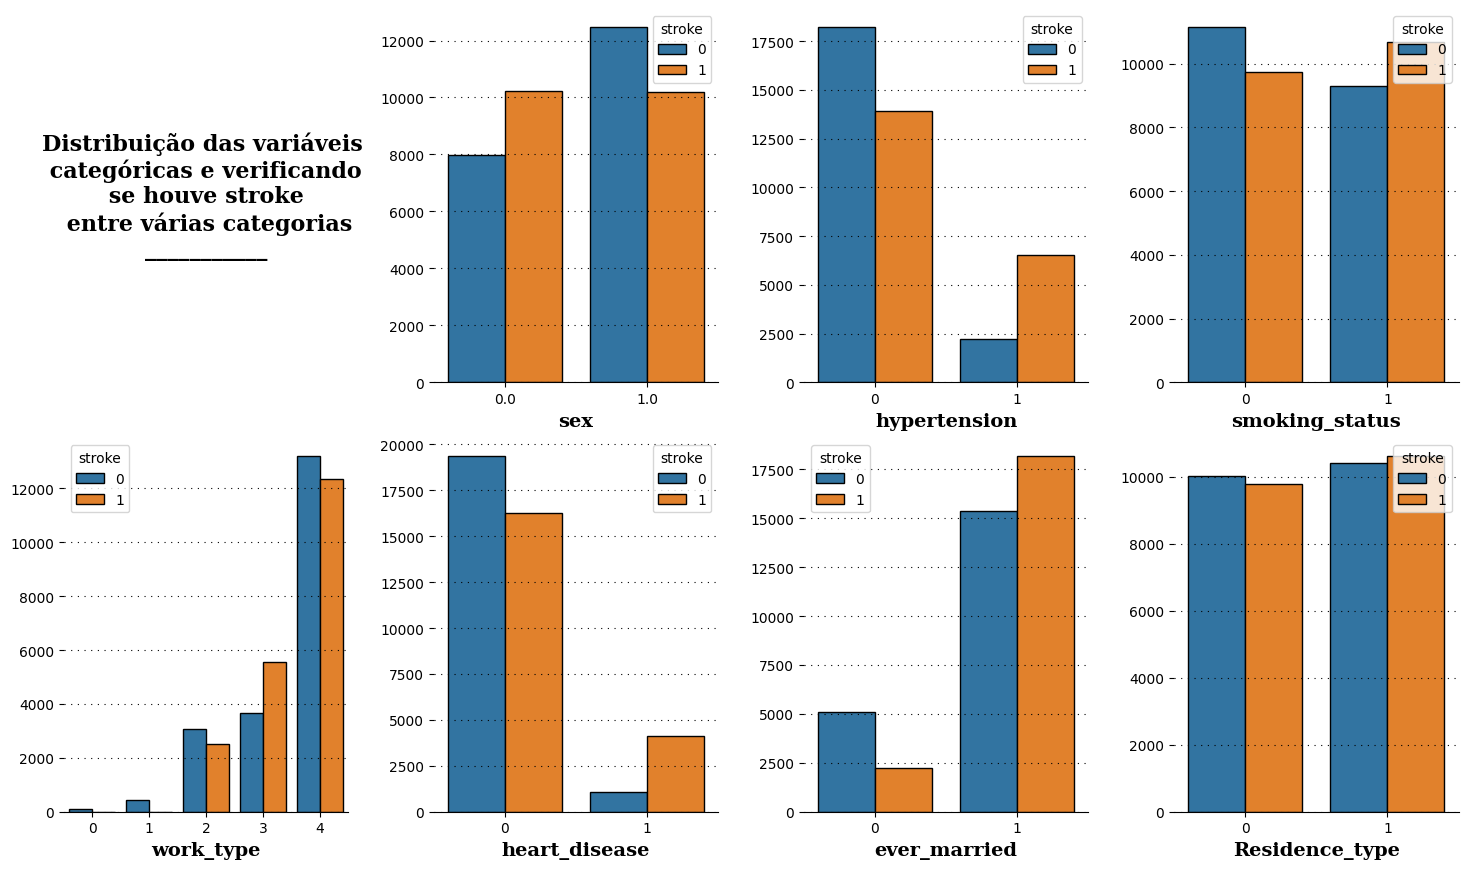

In [ ]:
train = df_stroke.copy()
fig = plt.figure(figsize=(18,16))
gs = fig.add_gridspec(3,4)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[1,2])
ax5 = fig.add_subplot(gs[-2,0])
ax6 = fig.add_subplot(gs[1,3])
ax7 = fig.add_subplot(gs[0,3])

# Titulo geral da plotagem
ax0.text(0.5,0.5,"Distribuição das variáveis \n categóricas e verificando \n se houve stroke \n entre várias categorias\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 16,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')

ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# performance of each field Count
'','', '', '', '', 'Residence_type', 'smoking_status'

ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1, data=train, x='sex',hue='stroke',edgecolor='black')
ax1.set_xlabel("sex",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.set_ylabel("",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")

ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax2, data=train, x='hypertension',hue='stroke',edgecolor='black')
ax2.set_xlabel("hypertension",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.set_ylabel("",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")

ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax3, data=train, x='heart_disease',hue='stroke',edgecolor='black')
ax3.set_xlabel("heart_disease",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.set_ylabel("",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")

ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax4, data=train, x='ever_married',hue='stroke',edgecolor='black')
ax4.set_xlabel("ever_married",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.set_ylabel("",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")

ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax5, data=train, x='work_type',hue='stroke',edgecolor='black')
ax5.set_xlabel("work_type",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.set_ylabel("",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")

ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax6, data=train, x='Residence_type',hue='stroke',edgecolor='black')
ax6.set_xlabel("Residence_type",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax6.set_ylabel("",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")

ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax7, data=train, x='smoking_status',hue='stroke',edgecolor='black')
ax7.set_xlabel("smoking_status",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax7.set_ylabel("",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")

ax0.spines["top"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["right"].set_visible(False)

ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.spines["right"].set_visible(False)

ax3.spines["top"].set_visible(False)
ax3.spines["left"].set_visible(False)
ax3.spines["right"].set_visible(False)

ax4.spines["top"].set_visible(False)
ax4.spines["left"].set_visible(False)
ax4.spines["right"].set_visible(False)

ax5.spines["top"].set_visible(False)
ax5.spines["left"].set_visible(False)
ax5.spines["right"].set_visible(False)

ax6.spines["top"].set_visible(False)
ax6.spines["left"].set_visible(False)
ax6.spines["right"].set_visible(False)

ax7.spines["top"].set_visible(False)
ax7.spines["left"].set_visible(False)
ax7.spines["right"].set_visible(False)

- Percebe-se que mulheres, hipertensos, pessoas com doença do coração, trabalhadores autônomos e fumantes são categorias que apresentaram maiores tendências a AVC que as outras existentes no conjunto de dados;

#### Distribuição da variável alvo

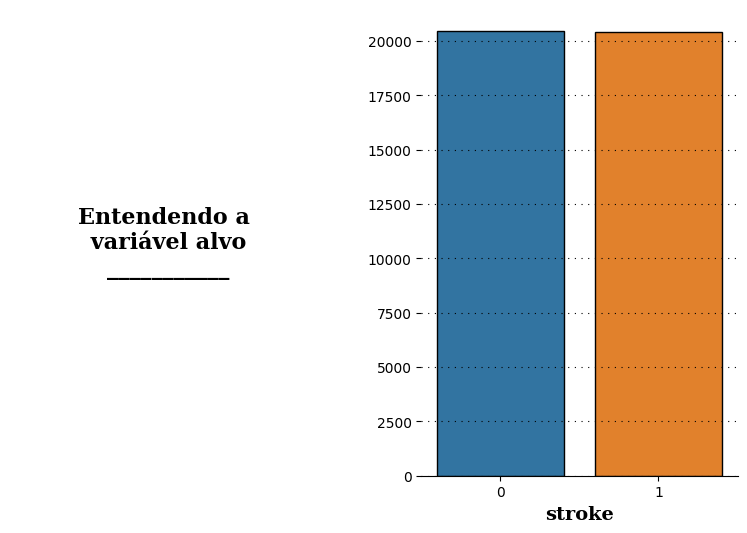

In [ ]:
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(3,4)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])


# Titulo da plotagem
ax0.text(0.5,0.5,"Entendendo a \n variável alvo \n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 16,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')

ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1, data=train, x='stroke',edgecolor='black')
ax1.set_xlabel("stroke",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.set_ylabel("",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")

ax0.spines["top"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["right"].set_visible(False)

ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)

In [ ]:
# Checando balanceamento das classes
dict_values = {0:'Não',1:'Sim'}
df_stroke['stroke'] = df_stroke['stroke'].map(dict_values)
df_stroke['stroke'].value_counts(normalize=True).to_frame().round(5)

,stroke
Não,0.50055
Sim,0.49945


Percebe-se pelo dataframe acima que os dados estão praticamente balanceados, o que é benéfico para um treinamento com boa performance sem a necessidade das operações de balanceamento de dados.

In [ ]:
dict_values = {0.0:'Feminino',1.0:'Masculino'}
df_stroke['sex'] = df_stroke['sex'].map(dict_values)
df_stroke['sex'].value_counts(normalize=True).to_frame().round(3)

,sex
Masculino,0.555
Feminino,0.445


- Aproximadamente 55.5% dos pacientes são homens, e 44.5% mulheres;

In [ ]:
dict_values = {0:'Não',1:'Sim'}
df_stroke['hypertension'] = df_stroke['hypertension'].map(dict_values)
df_stroke['hypertension'].value_counts(normalize=True).to_frame().round(3)

,hypertension
Não,0.786
Sim,0.214


78.6% dos pacientes não possuem hipertensão, e aproximadamente 21.5% das pessoas possuem;

In [ ]:
dict_values = {0:'Não',1:'Sim'}
df_stroke['heart_disease'] = df_stroke['heart_disease'].map(dict_values)
df_stroke['heart_disease'].value_counts(normalize=True).to_frame().round(3)

,heart_disease
Não,0.872
Sim,0.128


Cerca de 87% dos pacientes da base não possum doença cardíaca;

In [ ]:
dict_values = {0:'Não',1:'Sim'}
df_stroke['ever_married'] = df_stroke['ever_married'].map(dict_values)
df_stroke['ever_married'].value_counts(normalize=True).to_frame().round(3)

,ever_married
Sim,0.821
Não,0.179


82% dos pacientes nunca se casaram;

In [ ]:
dict_values = {0:'Nunca',1:'Criança',2:'Publico',3:'Autonomo',4:'Priv.'}
df_stroke['work_type'] = df_stroke['work_type'].map(dict_values)
df_stroke['work_type'].value_counts(normalize=True).to_frame().round(3)

,work_type
Priv.,0.625
Autonomo,0.226
Publico,0.137
Criança,0.011
Nunca,0.002


Grande parte dos pacientes ou são funcionários do setor privado, ou são autônomos (cerca de 85% dos casos);

In [ ]:
dict_values = {0:'Urbano',1:'Rural'}
df_stroke['Residence_type'] = df_stroke['Residence_type'].map(dict_values)
df_stroke['Residence_type'].value_counts(normalize=True).to_frame().round(3)

,Residence_type
Rural,0.515
Urbano,0.485


Exite um bom equilíbrio nos dados entre moradores da região urbana e rural;

In [ ]:
dict_values = {0:'Não',1:'Sim'}
df_stroke['smoking_status'] = df_stroke['smoking_status'].map(dict_values)
df_stroke['smoking_status'].value_counts(normalize=True).to_frame().round(3)

,smoking_status
Não,0.511
Sim,0.489


Os dados da variável "smoking status" também encontram-se praticamente balanceados entre "sim" e "não";

#### Distribuição das variáveis contínuas

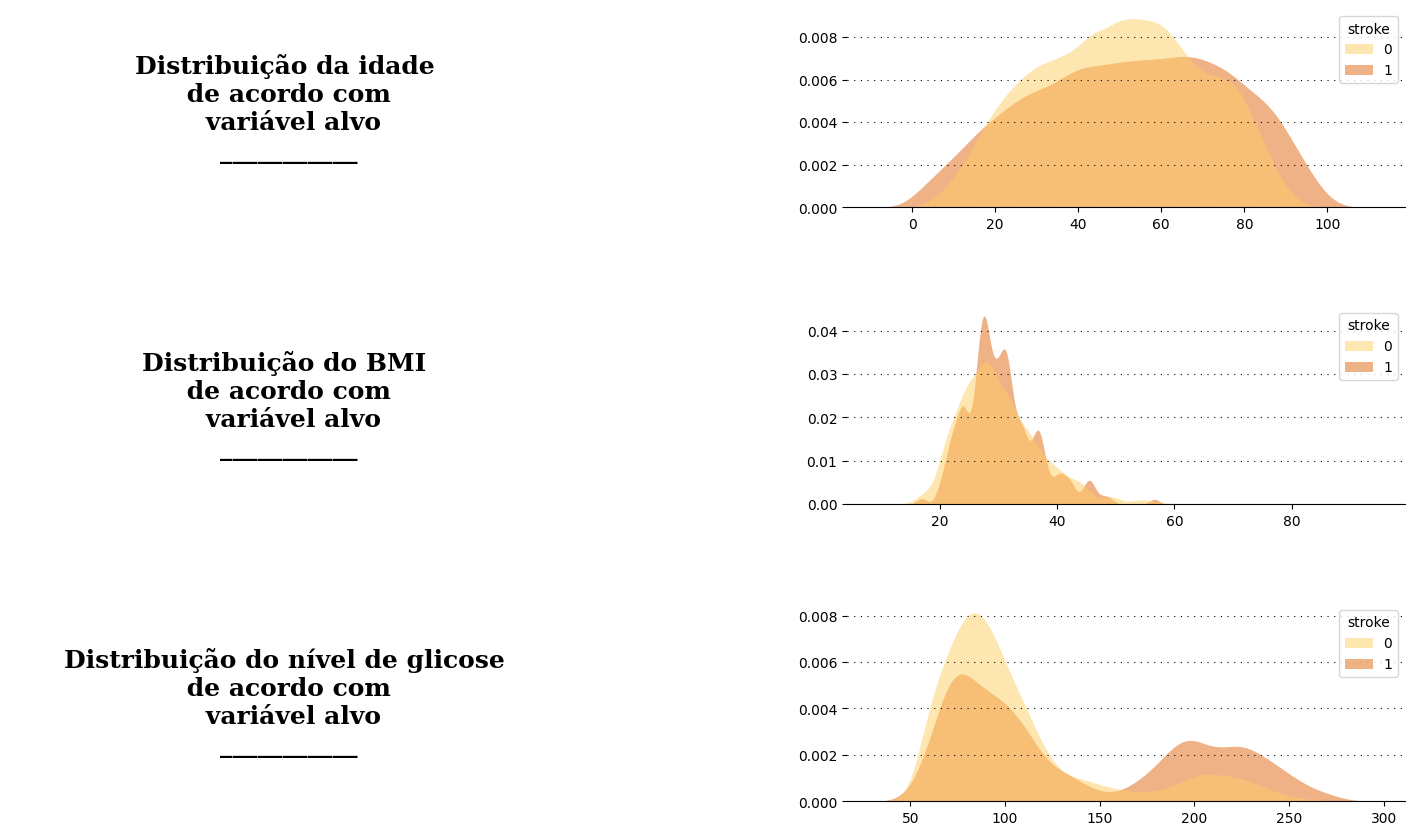

In [ ]:
fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(5,2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])


# Age titulo
ax0.text(0.5,0.5,"Distribuição da idade \n de acordo com \n variável alvo\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax0.spines["bottom"].set_visible(False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# Age
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax1, data=train, x='age',hue="stroke", fill=True,palette="YlOrBr", alpha=.5, linewidth=0)
ax1.set_xlabel("")
ax1.set_ylabel("")

# bmi titulo
ax2.text(0.5,0.5,"Distribuição do BMI \n de acordo com \n variável alvo\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax2.spines["bottom"].set_visible(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.tick_params(left=False, bottom=False)

# bmi
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax3, data=train, x='bmi',hue="stroke", fill=True,palette="YlOrBr", alpha=.5, linewidth=0)
ax3.set_xlabel("")
ax3.set_ylabel("")

# avg_glucose_level titulo
ax4.text(0.5,0.5,"Distribuição do nível de glicose \n de acordo com \n variável alvo\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax4.spines["bottom"].set_visible(False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.tick_params(left=False, bottom=False)

# avg_glucose_level
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax5, data=train, x='avg_glucose_level',hue="stroke", fill=True,palette="YlOrBr", alpha=.5, linewidth=0)
ax5.set_xlabel("")
ax5.set_ylabel("")



for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)
    ax5.spines[i].set_visible(False)

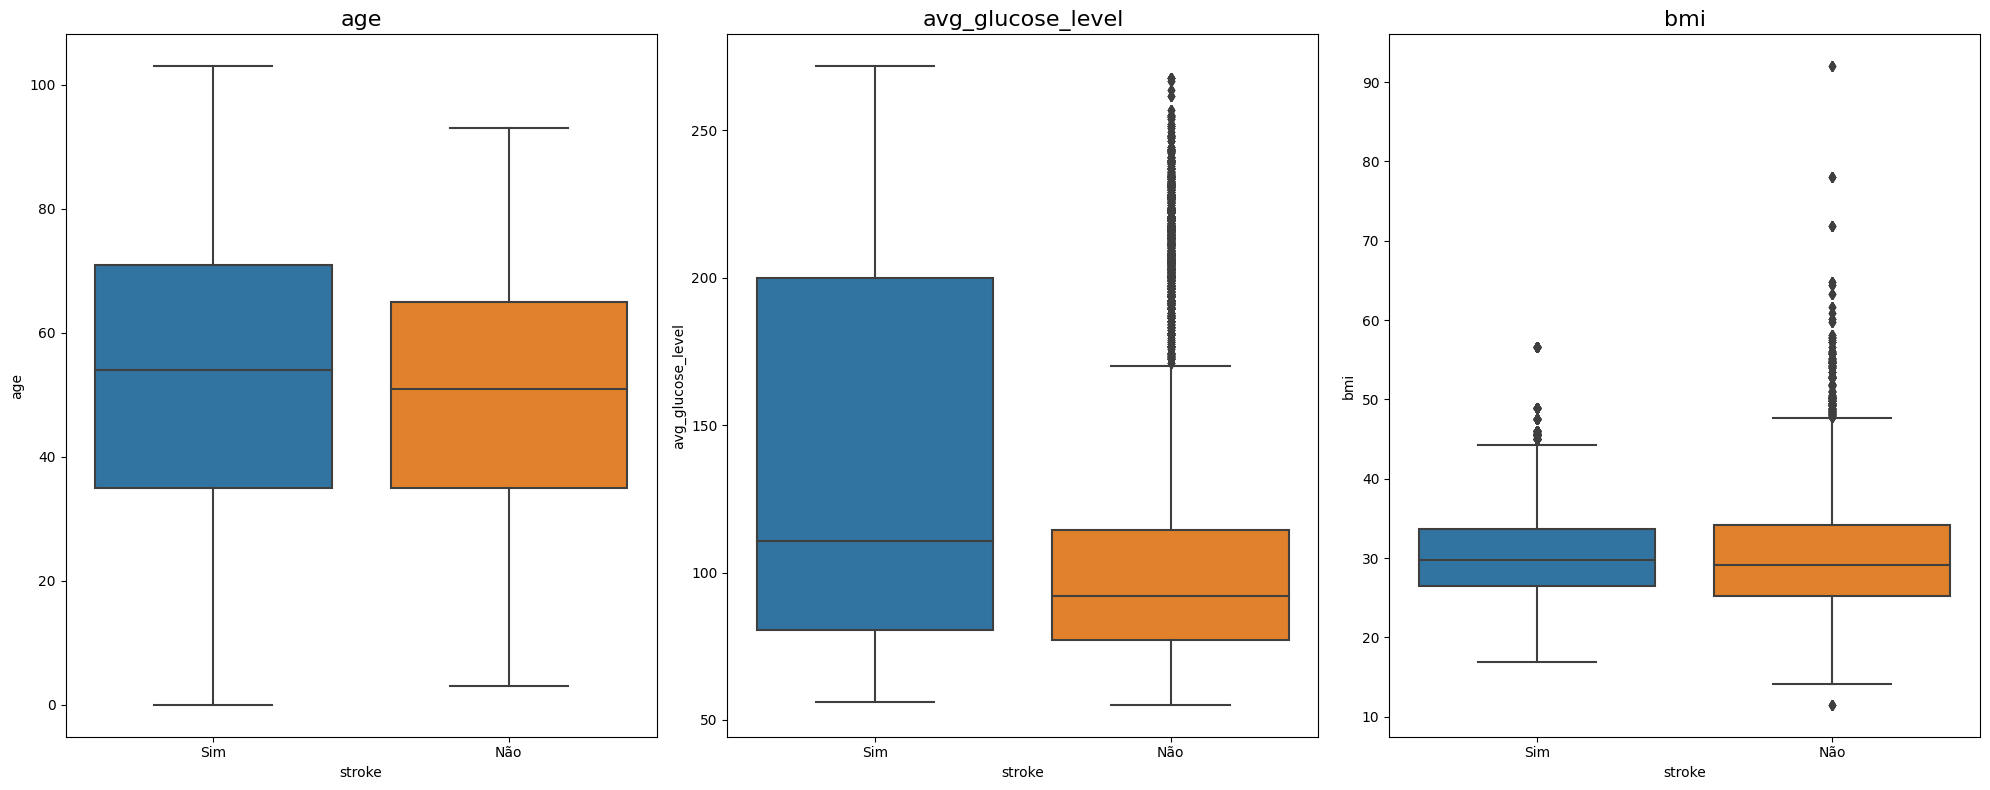

In [ ]:
# Checagem de outliers das variaveis numericas
numeric_columns = ['age','avg_glucose_level','bmi']
fig = plt.figure(figsize=(20,8))
for i in range(0,len(numeric_columns)):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(data=df_stroke,y=numeric_columns[i],x='stroke',ax=ax)
    ax.set_title(numeric_columns[i], size=16)

plt.tight_layout()
plt.show()

- Analisando os gráficos das variáveis numéricas, percebe-se que apenas a feature "bmi" apresenta outliers no caso dos pacientes que não possuem derrame. Os valores acima do limite superior são extremamente altos, mas como não temos certeza se são provenientes de inputs incorretos, manteremos dessa forma;
- Nota-se que a mediana da variável "bmi" apresentou valor elevado, de aproximadamente 30.0, sendo que esse valor já é considerado transição de sobrepeso para obesidade, e ficou semelhante para as duas opções do target.
- A mediana da variável "age" ficou por volta de 52 anos, indicando um grande número de pessoas de meia idade ou idosas, e com valores similares para casos positivos e negativos de derrame;
- Já no caso da variável "avg_glucose_level", a mediana ficou por volta de 90.0 para os pacientes sem derrame (valor dentro da normalidade), e em cerca de 110.0 para os pacientes com derrame, valor já fora do intervalo padrão da normalidade. Além disso, nota-se que o terceiro quartil para os casos positivos de AVC foi bem maior que para os casos negativos.

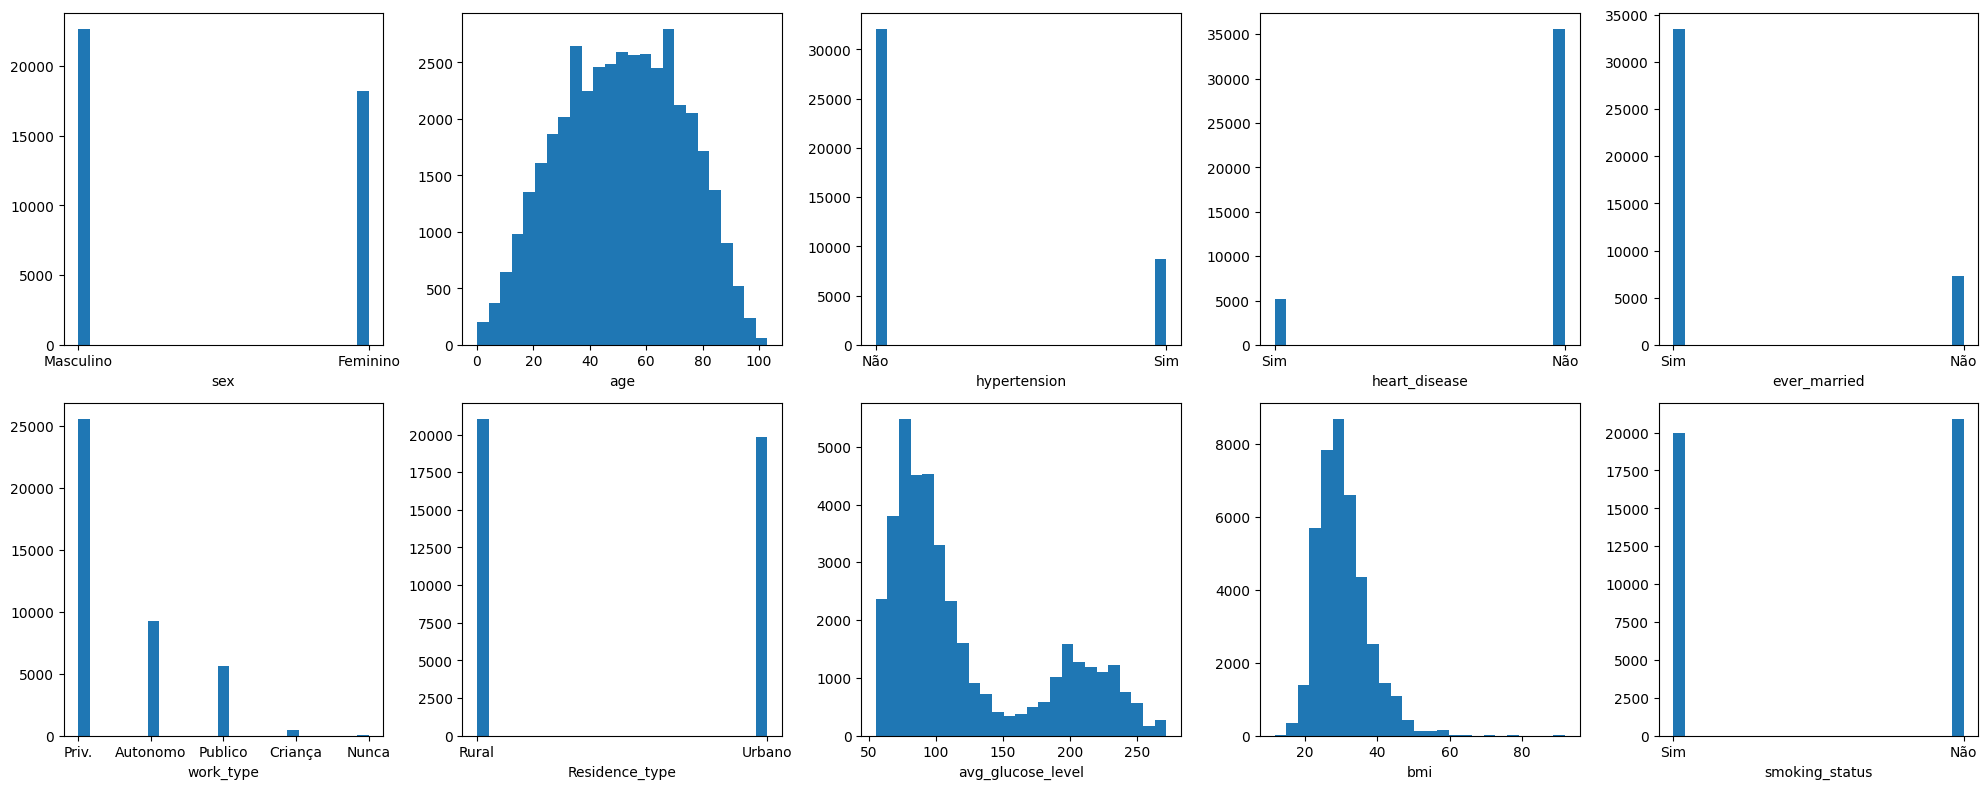

In [ ]:
# checando variância das colunas com histogramas
fig = plt.figure(figsize=(20,8))
for i in range(1,len(df_stroke.columns)):
    ax = fig.add_subplot(2, 5, i)
    ax.hist(df_stroke.iloc[:, i-1],bins=25)
    ax.set_xlabel(df_stroke.columns[i-1])
plt.tight_layout()
plt.show()

- Percebe-se pelos histogramas acima que não há nenhuma variável que apresenta apenas uma informação por coluna, e que existe uma boa distribuição  dos dados entre os seus valores únicos, de uma forma geral;
- Nota-se ainda que a variável "age" se distribui de forma muito próxima a uma normal, já "bmi" e "avg_glucose_level" apresentam mais assimetria em suas distribuições; 

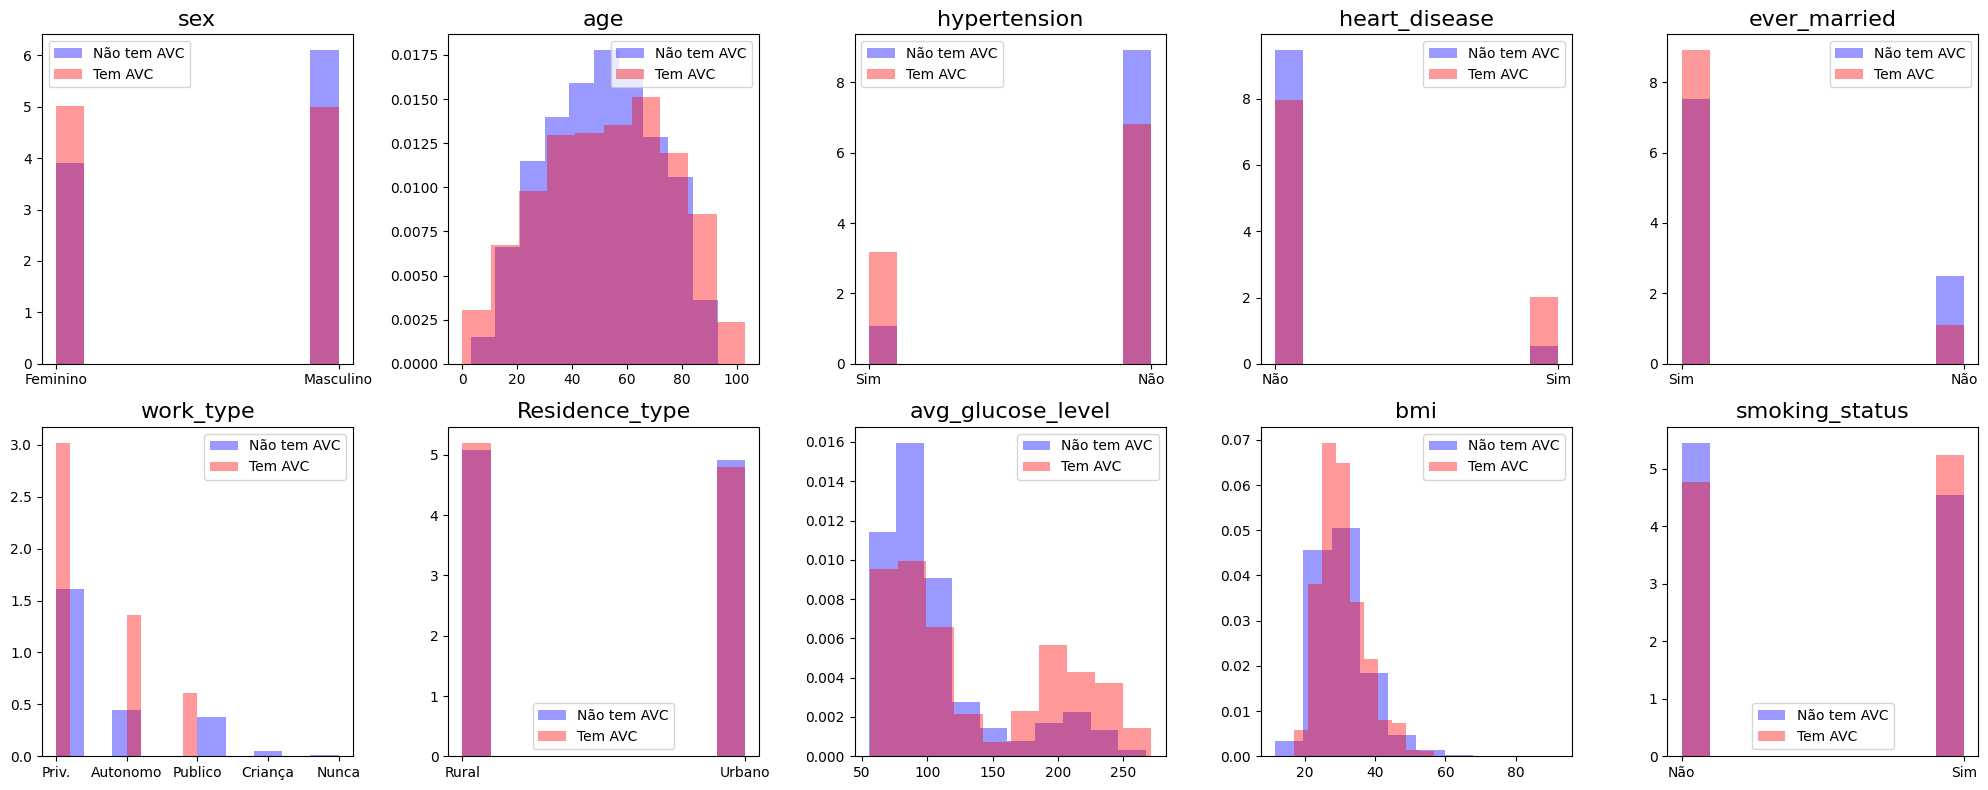

In [ ]:
# comparação entre histogramas separados pela classe
fig = plt.figure(figsize=(20,8))
for i in range(1,len(df_stroke.columns)):
    ax = fig.add_subplot(2, 5, i)
    ax.hist(df_stroke.loc[df_stroke['stroke'] == "Não",:].iloc[:, i-1], color='blue', alpha=0.4, 
            label='Não tem AVC', density=True)
    ax.hist(df_stroke.loc[df_stroke['stroke'] == "Sim",:].iloc[:, i-1], color='red', alpha=0.4,
            label='Tem AVC', density=True)
    ax.set_title(df_stroke.columns[i-1], size=16)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

- De forma geral, conseguimos visualizar que não há nenhuma variável que que separe de forma satisfatória casos positivos e negativos de derrame.
- Nota-se pelo gráfico da "avg_glucose_level" que existe uma concentração maior de casos de AVC para maiores níveis de glicose, e de forma análoga para "bmi", que concentra mais registros na faixa entre 30-40 para os casos positivos que para os negativos;

#### Matriz de correlação (Heatmap)

<Axes: >

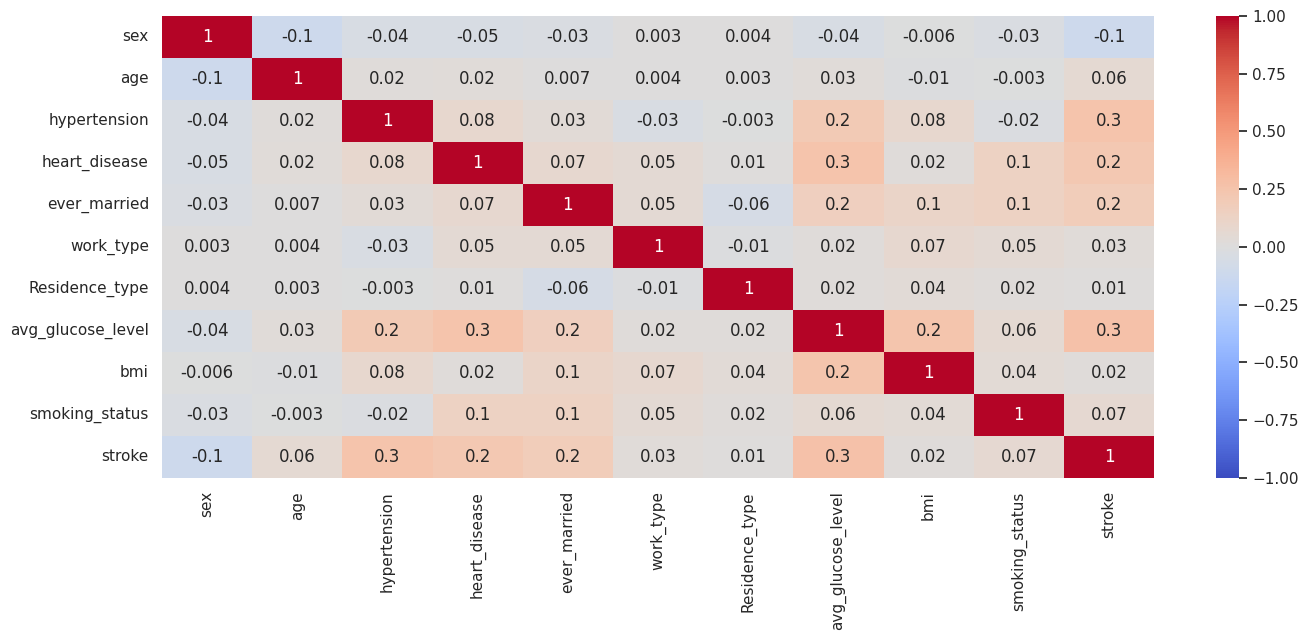

In [ ]:
# Checando correlação entre variáveis, para em caso de alta correlação eliminar uma delas
sns.set(rc = {'figure.figsize':(16,6)})
sns.heatmap(df_stroke_analysis.corr(),vmin=-1, vmax=1, annot = True, fmt='.1g',cmap= 'coolwarm')

Nenhuma das variáveis apresenta alta correlação positiva ou negativa com cada uma das features, sendo assim, não há a necessidade de remover nenhuma das colunas por essa razão.

#### Matriz de correlação de acordo com a variável alvo usando gráficos de dispersão (Pairplot)

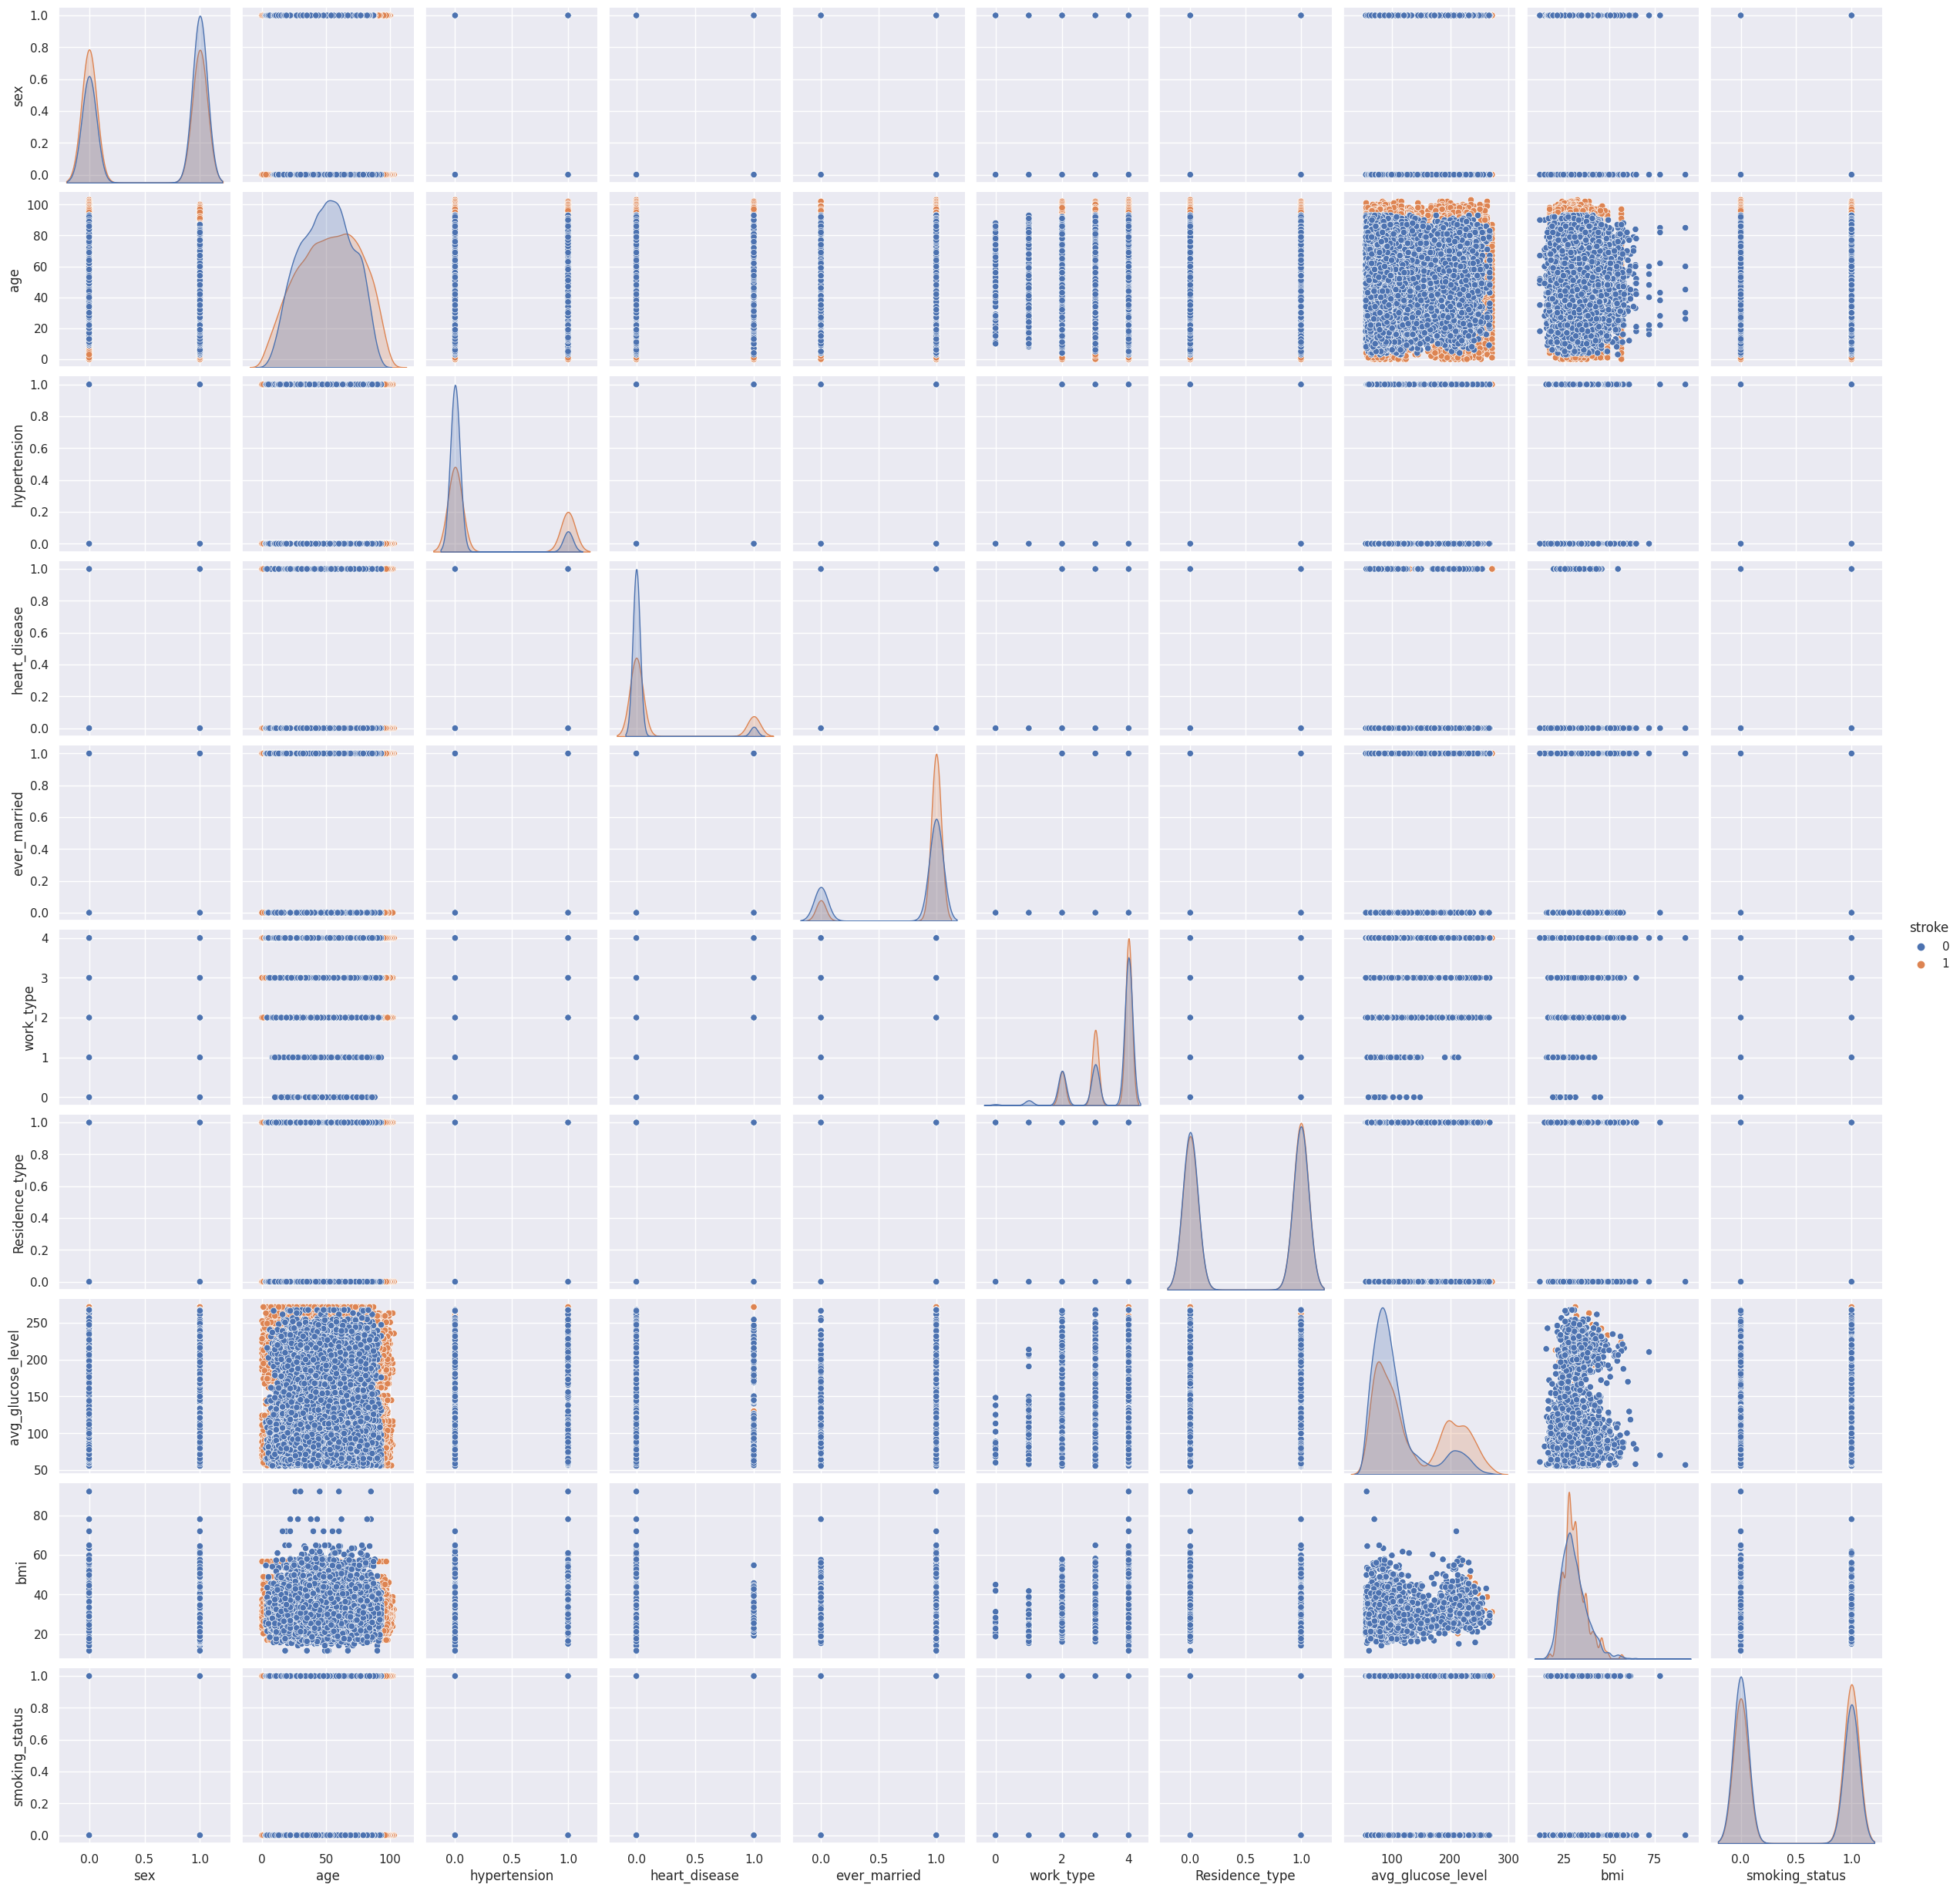

In [ ]:
sns.pairplot(train,hue='stroke')
plt.show()

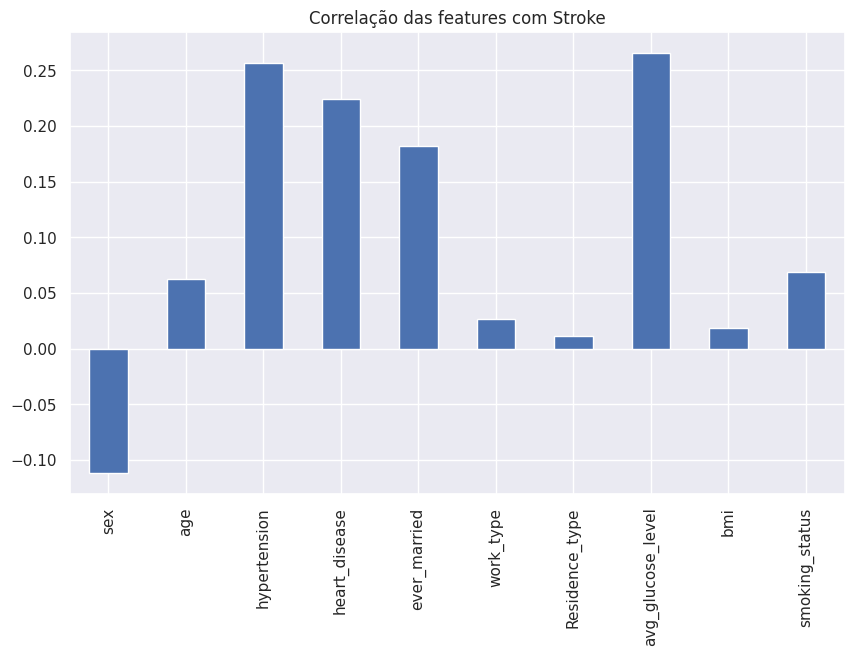

In [ ]:
# Correlação de cada uma das variáveis com o target
df_stroke_analysis.drop('stroke', axis=1).corrwith(df_stroke_analysis['stroke']).plot(kind='bar', grid=True, figsize=(10, 6), title="Correlação das features com Stroke");

Pelo gráfico acima, nota-se que as features que mais se correlacionam com o target são "avg_glucose_level","hypertension" e "heart_disease";

## Etapa de Modelagem

In [ ]:
# Ajustes nas colunas do dataframe reservado
df_stroke_analysis['sex'] = df_stroke_analysis['sex'].astype(int)
dict_values = {0:'Feminino',1:'Masculino'}
df_stroke_analysis['sex'] = df_stroke_analysis['sex'].map(dict_values)

dict_values = {0:'Nunca',1:'Criança',2:'Publico',3:'Autonomo',4:'Privado'}
df_stroke_analysis['work_type'] = df_stroke_analysis['work_type'].map(dict_values)

In [ ]:
# Separação de features e target
x = df_stroke_analysis.drop(columns=['stroke'])
y = df_stroke_analysis[['stroke']]

In [ ]:
# Split de treino e teste
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=2023)
print(f"Shape dados treino:{x_train.shape}, {y_train.shape}")
print(f"Shape dados teste: {x_test.shape}, {y_test.shape}")

Shape dados treino:(28594, 10), (28594, 1)
Shape dados teste: (12255, 10), (12255, 1)


In [ ]:
# Configurando objeto de validação cruzada (para evitar overfitting)
k_fold = StratifiedKFold(n_splits=4, shuffle=True, random_state=2023)

In [ ]:
# criaçãi de um pipeline de processamento para features numéricas
pipe_num = Pipeline([
    ('input_num', SimpleImputer(strategy='median'))
])

# definir quem são as features numéricas
feat_num = x.select_dtypes(include=np.number).columns.tolist()

# Pipeline para encoding de categoricas
pipe_categ = Pipeline([
    ('input_cat', SimpleImputer(strategy='constant', fill_value='none')),    
    ('encoder', OneHotEncoder(drop='first'))
])

# Features categoricas
feat_categ = x.select_dtypes(exclude=np.number).columns.tolist()

# Processamento das categoricas
process = ColumnTransformer([
    ('transf_num', pipe_num, feat_num),
    ('transf_categ', pipe_categ, feat_categ)
])

In [ ]:
# Criando pipelines para os modelos testados - KNN, Decision Tree, Random Forest, Gradient Boosting
# KNN
knn_pipe = Pipeline([
    ('process',process),
    ('seletor', SelectKBest(f_classif)),
    ('scaler', RobustScaler()),
    ('model', KNeighborsClassifier())
])

# Decision Tree
dt_pipe = Pipeline([
    ('process',process),
    ('seletor', SelectKBest(f_classif)),
    ('scaler', RobustScaler()),
    ('model', DecisionTreeClassifier(random_state=2023))
])

# Random Forest
rf_pipe = Pipeline([
    ('process', process),
    ('seletor', SelectKBest(f_classif)),
    ('scaler', RobustScaler()),
    ('model', RandomForestClassifier(random_state=2023,n_jobs=4))
])

# Gradient Boosting
gb_pipe = Pipeline([
    ('process', process),
    ('seletor', SelectKBest(f_classif)),
    ('scaler', RobustScaler()),
    ('model', GradientBoostingClassifier(random_state=2023))
])

In [ ]:
# Dicionario de parametros para os GridSearchs
knn_params = {
    'seletor__k': [5, 7, 9], 
    'model__n_neighbors': [5, 15, 25, 50] # 3 ficou muito bom, mas talvez esteja overfitando
}

dt_params = {
    'seletor__k': [5, 7, 9],
    'model__max_depth': [3, 5, 8],
}

rf_params = {
    'seletor__k': [5, 7, 9],
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [3, 7],
}

gb_params = {
    'seletor__k': [5, 7, 9],
    'model__n_estimators': [100, 250, 1000],
    'model__learning_rate': [0.001, 0.01]
}

In [ ]:
# Instancia dos objetos de campos de busca (GridSearch)
knn_search = GridSearchCV(
    estimator=knn_pipe,
    param_grid=knn_params,
    cv=k_fold,
    scoring='f1',
    refit=True,
    error_score=0
)

dt_search = GridSearchCV(
    estimator=dt_pipe,
    param_grid=dt_params,
    cv=k_fold,
    scoring='f1',
    refit=True,
    error_score=0
)

# criando o objeto de busca do Random Forest
rf_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_params,
    cv=k_fold,
    scoring='f1',
    refit=True,
    error_score=0,
)

# Criando objeto de busca do Gradient Boosting
gb_search = GridSearchCV(
    estimator=gb_pipe,
    param_grid=gb_params,
    cv=k_fold,
    scoring='f1',
    refit=True,
    error_score=0,
)

In [ ]:
# Treino pipeline KNN
knn_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=2023, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('process',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['age',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'ever_married',
                                                                          'Residence_type',
                                                                          'avg_glucose_level',
                                                                          'bmi',
                                                                          'smoking_status']),
                                                                        ('transf_categ',
                                                                         Pipeline(steps=[('input_cat',
                                                                                          SimpleImputer(fill_value='none',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['sex',
                                                                          'work_type'])])),
                                       ('seletor', SelectKBest()),
                                       ('scaler', RobustScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [5, 15, 25, 50],
                         'seletor__k': [5, 7, 9]},
             scoring='f1')

In [ ]:
# Treino pipeline DT
dt_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=2023, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('process',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['age',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'ever_married',
                                                                          'Residence_type',
                                                                          'avg_glucose_level',
                                                                          'bmi',
                                                                          'smoking_status']),
                                                                        ('transf_categ',
                                                                         Pipeline(steps=[('input_cat',
                                                                                          SimpleImputer(fill_value='none',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['sex',
                                                                          'work_type'])])),
                                       ('seletor', SelectKBest()),
                                       ('scaler', RobustScaler()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=2023))]),
             param_grid={'model__max_depth': [3, 5, 8],
                         'seletor__k': [5, 7, 9]},
             scoring='f1')

In [ ]:
# Treino pipeline RF
rf_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=2023, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('process',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['age',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'ever_married',
                                                                          'Residence_type',
                                                                          'avg_glucose_level',
                                                                          'bmi',
                                                                          'smoking_status']...
                                                                         Pipeline(steps=[('input_cat',
                                                                                          SimpleImputer(fill_value='none',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['sex',
                                                                          'work_type'])])),
                                       ('seletor', SelectKBest()),
                                       ('scaler', RobustScaler()),
                                       ('model',
                                        RandomForestClassifier(n_jobs=4,
                                                               random_state=2023))]),
             param_grid={'model__max_depth': [3, 7],
                         'model__n_estimators': [100, 200, 500],
                         'seletor__k': [5, 7, 9]},
             scoring='f1')

In [ ]:
# Treino pipeline GB
gb_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=2023, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('process',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['age',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'ever_married',
                                                                          'Residence_type',
                                                                          'avg_glucose_level',
                                                                          'bmi',
                                                                          'smoking_status']...
                                                                                          SimpleImputer(fill_value='none',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['sex',
                                                                          'work_type'])])),
                                       ('seletor', SelectKBest()),
                                       ('scaler', RobustScaler()),
                                       ('model',
                                        GradientBoostingClassifier(random_state=2023))]),
             param_grid={'model__learning_rate': [0.001, 0.01],
                         'model__n_estimators': [100, 250, 1000],
                         'seletor__k': [5, 7, 9]},
             scoring='f1')

In [ ]:
# Melhores valores de parâmetros
print('KNN:', knn_search.best_params_)
print('Árvore de Decisão:', dt_search.best_params_)
print('Random Forest:', rf_search.best_params_)
print('Gradient Boosting:', gb_search.best_params_)

KNN: {'model__n_neighbors': 5, 'seletor__k': 5}
Árvore de Decisão: {'model__max_depth': 8, 'seletor__k': 5}
Random Forest: {'model__max_depth': 7, 'model__n_estimators': 200, 'seletor__k': 7}
Gradient Boosting: {'model__learning_rate': 0.01, 'model__n_estimators': 1000, 'seletor__k': 5}


In [ ]:
# Print dos melhores scores
print('KNN:', knn_search.best_score_)
print('Árvore de Decisão:', dt_search.best_score_)
print('Random Forest:', rf_search.best_score_)
print('Gradient Boosting:', gb_search.best_score_)

KNN: 0.9812326186706444
Árvore de Decisão: 0.7290092440040904
Random Forest: 0.7212147193498377
Gradient Boosting: 0.7673708935679768


In [ ]:
# Previsões na base de treino
yhat_train_knn = knn_search.best_estimator_.predict(x_train)
yhat_train_dt = dt_search.best_estimator_.predict(x_train)
yhat_train_rf = rf_search.best_estimator_.predict(x_train)
yhat_train_gb = gb_search.best_estimator_.predict(x_train)

# Métrica de avaliação - F1-Score
print('F1-Score KNN Treino: ', f1_score(y_train, yhat_train_knn))
print('F1-Score Decision Tree Treino: ', f1_score(y_train, yhat_train_dt))
print('F1-Score Random Forest Treino: ', f1_score(y_train, yhat_train_rf))
print('F1-Score Gradient Boosting Treino: ', f1_score(y_train, yhat_train_gb))

F1-Score KNN Treino:  0.9900516482373738
F1-Score Decision Tree Treino:  0.7145592275035378
F1-Score Random Forest Treino:  0.729871912168344
F1-Score Gradient Boosting Treino:  0.7645096731154103


In [ ]:
# Previsões na base de teste
yhat_test_knn = knn_search.best_estimator_.predict(x_test)
yhat_test_dt = dt_search.best_estimator_.predict(x_test)
yhat_test_rf = rf_search.best_estimator_.predict(x_test)
yhat_test_gb = gb_search.best_estimator_.predict(x_test)

# Métrica de avaliação - F1-Score
print('F1-Score KNN Teste: ', f1_score(y_test, yhat_test_knn))
print('F1-Score Decision Tree', f1_score(y_test, yhat_test_dt))
print('F1-Score Random Forest Teste: ', f1_score(y_test, yhat_test_rf))
print('F1-Score Gradient Boosting Teste: ', f1_score(y_test, yhat_test_gb))

F1-Score KNN Teste:  0.9792033274676051
F1-Score Decision Tree 0.708799691238904
F1-Score Random Forest Teste:  0.7242660063671738
F1-Score Gradient Boosting Teste:  0.761265909872721


In [ ]:
# Classif. Reports de treino
print('Treino KNN:\n',classification_report(y_train,yhat_train_knn))
print("\n")
print('Treino DT:\n',classification_report(y_train,yhat_train_dt))
print("\n")
print('Treino RF:\n',classification_report(y_train,yhat_train_rf))
print("\n")
print("Treino GB:\n",classification_report(y_train, yhat_train_gb))

Treino KNN:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     14313
           1       0.98      1.00      0.99     14281

    accuracy                           0.99     28594
   macro avg       0.99      0.99      0.99     28594
weighted avg       0.99      0.99      0.99     28594



Treino DT:
               precision    recall  f1-score   support

           0       0.70      0.92      0.79     14313
           1       0.88      0.60      0.71     14281

    accuracy                           0.76     28594
   macro avg       0.79      0.76      0.75     28594
weighted avg       0.79      0.76      0.75     28594



Treino RF:
               precision    recall  f1-score   support

           0       0.72      0.83      0.77     14313
           1       0.80      0.67      0.73     14281

    accuracy                           0.75     28594
   macro avg       0.76      0.75      0.75     28594
weighted avg       0.76      0.75

In [ ]:
# Classif. Reports de teste
print('Teste KNN:\n',classification_report(y_test,yhat_test_knn))
print("\n")
print('Teste DT:\n',classification_report(y_test,yhat_test_dt))
print("\n")
print('Teste RF:\n',classification_report(y_test,yhat_test_rf))
print("\n")
print("Teste GB:\n",classification_report(y_test, yhat_test_gb))

Teste KNN:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      6134
           1       0.96      1.00      0.98      6121

    accuracy                           0.98     12255
   macro avg       0.98      0.98      0.98     12255
weighted avg       0.98      0.98      0.98     12255



Teste DT:
               precision    recall  f1-score   support

           0       0.69      0.91      0.79      6134
           1       0.87      0.60      0.71      6121

    accuracy                           0.75     12255
   macro avg       0.78      0.75      0.75     12255
weighted avg       0.78      0.75      0.75     12255



Teste RF:
               precision    recall  f1-score   support

           0       0.71      0.82      0.76      6134
           1       0.79      0.67      0.72      6121

    accuracy                           0.75     12255
   macro avg       0.75      0.75      0.74     12255
weighted avg       0.75      0.75   

- Analisando os resultados acima, percebe-se que o modelo do tipo KNN foi o que performou melhor em todas as métricas verificadas (accuracy, precision, recall e f1-score);
- Na base de treino, o KNN obteve 99% da métrica f1-score, e na teste, obteve 98% de f1-score, valor bem acima dos obtidos nos outros modelos, que ficaram na faixa de 75%, aproximadamente;
- Como o f1-score é a métrica principal na análise, e desejamos evitar tanto falsos negativos quanto falsos positivos, o KNN torna-se a melhor opção de forma evidente;